# Case Study 1 (Working file)

### Introduction

Knowing the location of business-critical machiney and/or workers is essential to optimize productivity for organizations that live and die by shipping times, workflow prioritization, deliverable timelines, and cost minimization. Real-time location systems (RTLS) have enabled some business to be in a position to monitor their assets through the production cycle. 

In this case study, we are evaluating the use of RTLS over wifi for an organization. Specifically, our authors (Nolan and Lang) posit that by distributing various wifi-enabled RTLS devices across the facility to assets, one might be able to use clustering methods to ascertain the predicted position of those assets based on past behavior. 

Specifically, we are seeking to perform the following:

+ Predict the location of the ONLINE data set leveraging two different clustering techniques
+ Compare our clustering approaches and results to identify the best-fit for the data
+ Discuss the 2 MACIDs that are located at the same position to describe which gives a higher perforance compared to the other
+ Discuss drawbacks using these methods to locate a real-time object
+ What method might overcome these perceived drawbacks?

### Background

## Imports

In [200]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# show all columns
pd.set_option('display.max_columns', None) 

#Set the seaborn plotting style
sns.set(style="darkgrid")

#set variables for font sizes for plots. This will allow them to be consistent within the notebook
titleFont = 25
axisFont = 15
labelFont = 15

## Create DataFrame

In [201]:
column_names = ['time', 'scanMac', 'posX', 'posY', 'posZ', 'orientation', 'mac', 'signal', 'channel', 'type']

lines = None
with open('../Data/offline.final.trace.txt', 'r') as file:
    lines = file.readlines()
    file.close()

instances = [] # will hold final data for dataframe

for line in lines:
    
    # strip "\n" from line
    line = line.rstrip('\n')
    
    # skip if comment
    if line[0] == '#':
        continue

    base = [] # [t, id, x, y, z, degree]
    rows = [] # base + [mac, signal, channel, type]

    for keyvalue in line.split(';'):
        key, value = keyvalue.split('=')

        if key in ['t', 'id', 'degree']:
            base.append(value)
        elif key == 'pos':
            # pos (x, y, z)
            base += value.split(',')
        else:
            # mac addresses and metrics (signal, channel, type)
            row = base.copy()
            row.append(key)
            row += value.split(',')
            rows.append(row)
    
    instances += rows

df = pd.DataFrame(instances, columns = column_names)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1181628 entries, 0 to 1181627
Data columns (total 10 columns):
time           1181628 non-null object
scanMac        1181628 non-null object
posX           1181628 non-null object
posY           1181628 non-null object
posZ           1181628 non-null object
orientation    1181628 non-null object
mac            1181628 non-null object
signal         1181628 non-null object
channel        1181628 non-null object
type           1181628 non-null object
dtypes: object(10)
memory usage: 90.2+ MB
None


,time,scanMac,posX,posY,posZ,orientation,mac,signal,channel,type
0,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:8a,-38,2437000000,3
1,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:90,-56,2427000000,3
2,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:0f:a3:39:e1:c0,-53,2462000000,3
3,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:8d,-65,2442000000,3
4,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:81,-65,2422000000,3


In [202]:
column_names = ['time', 'scanMac', 'posX', 'posY', 'posZ', 'orientation', 'mac', 'signal', 'channel', 'type']

lines = None
with open('../Data/online.final.trace.txt', 'r') as file:
    lines = file.readlines()
    file.close()

instances = [] # will hold final data for dataframe

for line in lines:
    
    # strip "\n" from line
    line = line.rstrip('\n')
    
    # skip if comment
    if line[0] == '#':
        continue

    base = [] # [t, id, x, y, z, degree]
    rows = [] # base + [mac, signal, channel, type]

    for keyvalue in line.split(';'):
        key, value = keyvalue.split('=')

        if key in ['t', 'id', 'degree']:
            base.append(value)
        elif key == 'pos':
            # pos (x, y, z)
            base += value.split(',')
        else:
            # mac addresses and metrics (signal, channel, type)
            row = base.copy()
            row.append(key)
            row += value.split(',')
            rows.append(row)
    
    instances += rows

df_online = pd.DataFrame(instances, columns = column_names)

print(df_online.info())
df_online.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53303 entries, 0 to 53302
Data columns (total 10 columns):
time           53303 non-null object
scanMac        53303 non-null object
posX           53303 non-null object
posY           53303 non-null object
posZ           53303 non-null object
orientation    53303 non-null object
mac            53303 non-null object
signal         53303 non-null object
channel        53303 non-null object
type           53303 non-null object
dtypes: object(10)
memory usage: 4.1+ MB
None


,time,scanMac,posX,posY,posZ,orientation,mac,signal,channel,type
0,1139692477303,00:02:2D:21:0F:33,0.0,0.05,0.0,130.5,00:14:bf:b1:97:8a,-43,2437000000,3
1,1139692477303,00:02:2D:21:0F:33,0.0,0.05,0.0,130.5,00:0f:a3:39:e1:c0,-52,2462000000,3
2,1139692477303,00:02:2D:21:0F:33,0.0,0.05,0.0,130.5,00:14:bf:3b:c7:c6,-62,2432000000,3
3,1139692477303,00:02:2D:21:0F:33,0.0,0.05,0.0,130.5,00:14:bf:b1:97:81,-58,2422000000,3
4,1139692477303,00:02:2D:21:0F:33,0.0,0.05,0.0,130.5,00:14:bf:b1:97:8d,-62,2442000000,3


## Exploratory Data Analysis (EDA)

In [203]:
df['mac'].value_counts()

00:0f:a3:39:e1:c0    145862
00:0f:a3:39:dd:cd    145619
00:14:bf:b1:97:8a    132962
00:14:bf:3b:c7:c6    126529
00:14:bf:b1:97:90    122315
00:14:bf:b1:97:8d    121325
00:14:bf:b1:97:81    120339
02:00:42:55:31:00    103887
02:64:fb:68:52:e6     50852
00:0f:a3:39:e0:4b     43508
02:2e:58:22:f1:ac     25112
00:0f:a3:39:e2:10     19162
02:37:fd:3b:54:b5      8732
02:b7:00:bb:a9:35      7602
02:5c:e0:50:49:de      6997
00:04:0e:5c:23:fc       418
00:30:bd:f8:7f:c5       301
00:e0:63:82:8b:a9       103
02:42:1c:4e:b5:c0         1
02:0a:3d:06:94:88         1
02:4f:99:43:30:cd         1
Name: mac, dtype: int64

In [204]:
# Drop MAC Ids that have a large abundance of nulls
rows_to_drop = ['02:64:fb:68:52:e6','00:0f:a3:39:e0:4b','02:2e:58:22:f1:ac','00:0f:a3:39:e2:10','02:37:fd:3b:54:b5','02:b7:00:bb:a9:35','02:5c:e0:50:49:de','00:04:0e:5c:23:fc','00:30:bd:f8:7f:c5','00:e0:63:82:8b:a9','02:42:1c:4e:b5:c0','02:0a:3d:06:94:88','02:4f:99:43:30:cd']

df = df[~df['mac'].str.contains('|'.join(rows_to_drop))]

#### We observe that signal strength tends to hover around the -58 or so average across the MAC IDs with some clear outliers3 C0 in particular seems to have a stronger overall signal strength and CD.

Text(0.5, 1.0, 'Signal Strength Distributions Across MAC IDs')

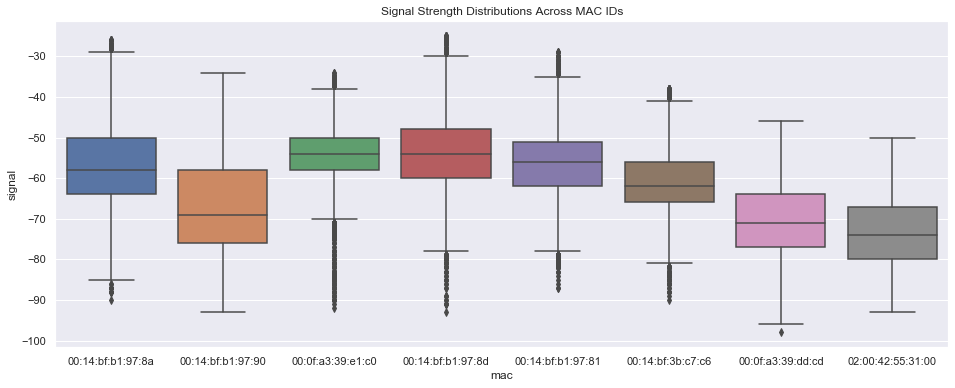

In [206]:
# Boxplot to see signal strength across MAC IDs
plt.figure(figsize=(16, 6))
sns.boxplot(x=df["mac"].astype(str), y=df['signal'].astype(int),data = df).set_title('Signal Strength Distributions Across MAC IDs')

In [144]:
# Drop additional rows with nulls
df = df.dropna()

In [145]:
df['mac'].value_counts()

00:0f:a3:39:e1:c0    145862
00:0f:a3:39:dd:cd    145619
00:14:bf:b1:97:8a    132962
00:14:bf:3b:c7:c6    126529
00:14:bf:b1:97:90    122315
00:14:bf:b1:97:8d    121325
00:14:bf:b1:97:81    120339
02:00:42:55:31:00    103887
Name: mac, dtype: int64

#### Here we one-hot encode the categorical columns enable KNN to process the data and perform clustering

In [171]:
#one hot encoding offline
cols_to_transform = ['mac','scanMac','channel']

df2 = pd.get_dummies(df, columns = cols_to_transform)

### Including MAC IDs ending C0 (and all others but excluding CD)

Weighted KNN appears to produce a better prediction against the test/train split OFFLINE data at .95 compared to .92 using the accuracy score and a k of 5.

In [146]:
# Withhold CD from DF
df = df[df['mac'].str[15:17] != 'cd']

In [147]:
# Sample 20% of rows to decrease run time
df = df.sample(frac=0.20)

In [152]:
# Attributes vs. Label split - Offline data
x = df2.iloc[:, :-1].values
y = df2.iloc[:, 4].values

In [153]:
# Split into test / train on the offline data (assuming we cannot even see the online data)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

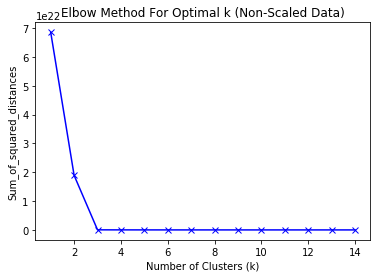

In [154]:
# Create elbow plot for sanity check on number of clusters - unscaled data
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df2)
    Sum_of_squared_distances.append(km.inertia_)
    
# Plot the appropriate k cluster size
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k (Non-Scaled Data)')
plt.show()

In [155]:
# Scale the data - offline
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

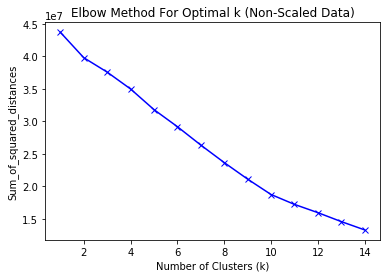

In [156]:
# Create elbow plot for sanity check on number of clusters - scaled data
# Optimal K = 11?
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df2_scaled)
    Sum_of_squared_distances.append(km.inertia_)
    
# Plot the appropriate k cluster size
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k (Non-Scaled Data)')
plt.show()

In [157]:
# Create KNN plot - unweighted
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [158]:
y_pred = classifier.predict(X_test)

In [159]:
# Confusion matrix results - avg. precision = .84 / .92  | avg. recall = .83 / .92  |  accuracy = .92
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[402   9   2 ...   0   0   0]
 [  3 334   3 ...   0   0   0]
 [  2   2 372 ...   0   0   0]
 ...
 [  0   0   0 ...  29   0   0]
 [  0   0   0 ...   0  17   0]
 [  0   0   0 ...   0   0  38]]


F:\Anaconda\envs\ML7331\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94       422
         0.1       0.91      0.92      0.92       362
         0.2       0.94      0.97      0.95       385
         0.3       0.91      0.92      0.92       502
         0.4       0.93      0.95      0.94       406
         0.5       0.93      0.92      0.93       271
         0.6       0.97      0.91      0.94       252
         0.7       0.96      0.93      0.94       349
         0.8       0.90      0.90      0.90        83
         0.9       0.84      0.92      0.88        61
         1.0       0.95      0.98      0.97        60
         1.2       0.91      0.83      0.87        60
         1.5       0.89      0.87      0.88       166
       134.0       0.00      0.00      0.00         1
       134.2       0.85      0.99      0.91        69
       134.3       0.91      0.95      0.93        64
       134.4       0.88      0.84      0.86        87
       134.5       0.92    

In [160]:
# Checking the K assumption and plotting all possible K values from 1-40 to see which yields the best mean error rate
error = []

# Calculating error for K values between 1 and 20
for i in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

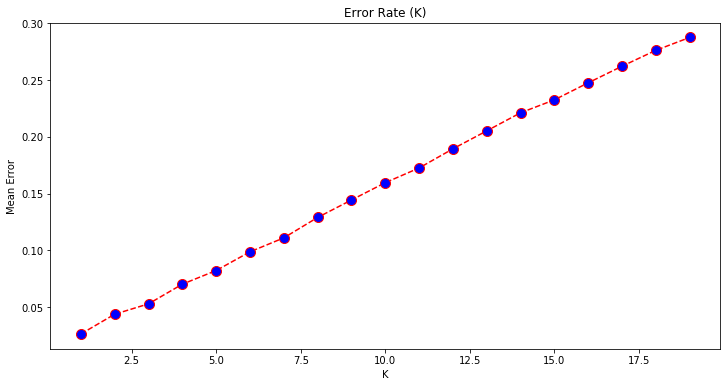

In [168]:
# Plot K - mean error is lowest around k between 0-10

plt.figure(figsize=(12, 6))
plt.plot(range(1, 20), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate (K)')
plt.xlabel('K')
plt.ylabel('Mean Error')

In [162]:
# Create KNN plot - weighted
classifier = KNeighborsClassifier(n_neighbors=5, weights = 'distance')
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

In [163]:
y_pred = classifier.predict(X_test)

In [164]:
# Confusion matrix results - precision .87 / .95  |  accuracy .86 / .95  |  accuracy .95
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[411   5   2 ...   0   0   0]
 [  2 345   1 ...   0   0   0]
 [  2   1 373 ...   0   0   0]
 ...
 [  0   0   0 ...  29   0   0]
 [  0   0   0 ...   0  20   0]
 [  0   0   0 ...   0   0  39]]


F:\Anaconda\envs\ML7331\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96       422
         0.1       0.92      0.95      0.94       362
         0.2       0.95      0.97      0.96       385
         0.3       0.96      0.94      0.95       502
         0.4       0.95      0.97      0.96       406
         0.5       0.97      0.95      0.96       271
         0.6       0.97      0.93      0.95       252
         0.7       0.97      0.95      0.96       349
         0.8       0.94      0.94      0.94        83
         0.9       0.90      0.93      0.92        61
         1.0       0.97      1.00      0.98        60
         1.2       0.95      0.88      0.91        60
         1.5       0.93      0.93      0.93       166
       134.0       0.00      0.00      0.00         1
       134.2       0.91      0.99      0.94        69
       134.3       0.95      0.97      0.96        64
       134.4       0.93      0.87      0.90        87
       134.5       0.94    

In [165]:
error = []

# Calculating error for K values between 1 and 20
for i in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

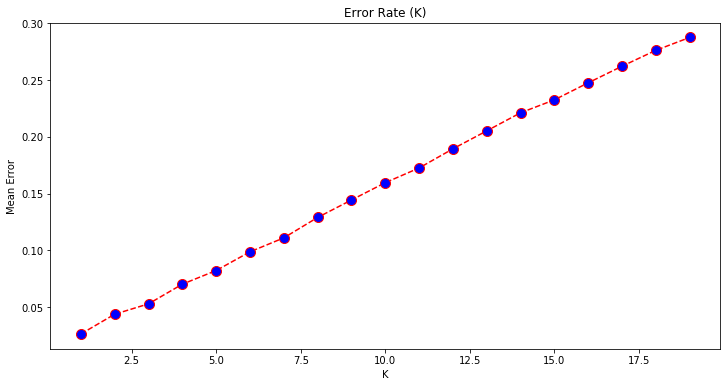

In [169]:
# Plot K

plt.figure(figsize=(12, 6))
plt.plot(range(1, 20), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate (K)')
plt.xlabel('K')
plt.ylabel('Mean Error')